In [161]:
import pandas as pd
import numpy as np
# 5. Calcular el radio de impacto del sismo (ejemplo)
magnitud_momento = 3
profundidad = 33 

def calcular_radio_impacto(magnitud_momento, profundidad):
    # Factores de ajuste
    factor_profundidad = 10 / (profundidad + 10)
    factor_magnitud = 10 ** (0.5 * magnitud_momento - 0.6)
    
    # Ajuste no lineal para magnitudes extremas
    if magnitud_momento < 5:
        factor_magnitud *= 1.2  
    elif magnitud_momento > 8:
        factor_magnitud *= 0.6
    
    r_km = factor_magnitud * factor_profundidad
    
    return r_km

R_km = calcular_radio_impacto(magnitud_momento, profundidad)

print(R_km)


1108.3649786850438


In [88]:
print(f'R_km: {R_km} ')

R_km: 2.216729957370088 


In [162]:

import geopandas as gpd
from shapely.geometry import shape, Point
from geopy.distance import geodesic

# 1. Cargar el archivo CSV
df = pd.read_csv('poblacion.csv', sep=';')

# 2. Crear una función para convertir GeoJSON a geometría Shapely
def convert_geojson_to_geometry(geojson_string):
    return shape(eval(geojson_string))

# 3. Aplicar la función para convertir GeoJSON a geometrías Shapely y crear un GeoDataFrame
df['geometry'] = df['Geo Shape'].apply(convert_geojson_to_geometry)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# 4. Definir el epicentro del sismo (ejemplo)
epicentro_lat = -12.04318
epicentro_lon = -77.02824

epicentro = Point(epicentro_lon, epicentro_lat)


# Convertir el radio de km a grados de longitud y latitud
R_deg_lon = R_km / (111.32 * np.cos(np.radians(epicentro_lat)))  # Longitud
R_deg_lat = R_km / 110.574  # Latitud

# 6. Crear un buffer circular alrededor del epicentro del sismo
area_de_efecto = epicentro.buffer(R_deg_lon)

# 7. Intersectar el área de efecto con los distritos en el GeoDataFrame
distritos_en_area_efecto = gdf[gdf['geometry'].intersects(area_de_efecto)]

# 8. Calcular la distancia geodésica desde el epicentro a cada distrito afectado
def calcular_distancia(geometry, epicentro):
    centroide_distrito = geometry.centroid
    distancia = geodesic((epicentro.y, epicentro.x), (centroide_distrito.y, centroide_distrito.x)).kilometers
    return distancia

distritos_en_area_efecto['DISTANCIA'] = distritos_en_area_efecto['geometry'].apply(lambda geom: calcular_distancia(geom, epicentro))

/home/leon/Documentos/UNSA/IA/articulo-ia/venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


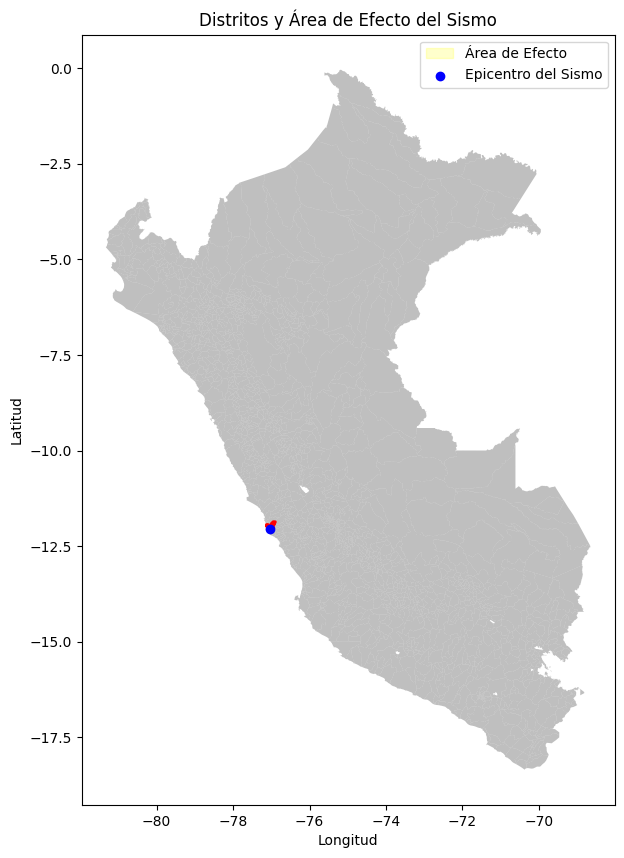

                 NOMBDIST NOMBPROV NOMBDEP  DISTANCIA  POBLACION
161                  LIMA     LIMA    LIMA   2.426336   293647.0
167                 BREÑA     LIMA    LIMA   3.010892    97431.0
228           EL AGUSTINO     LIMA    LIMA   4.444316   220858.0
809                 RIMAC     LIMA    LIMA   2.217403   190288.0
871  SAN MARTIN DE PORRES     LIMA    LIMA   8.612129   740749.0


In [160]:

# 9. Visualizar el resultado
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plotear los distritos que intersectan con el área de efecto
distritos_en_area_efecto.plot(ax=ax, edgecolor='red', facecolor='none')

# Plotear todos los distritos en transparencia
gdf.plot(ax=ax, alpha=0.5)

# Plotear el área de efecto del sismo
x, y = area_de_efecto.exterior.xy
ax.fill(x, y, alpha=0.2, color='yellow')

# Plotear el epicentro del sismo
ax.scatter(epicentro_lon, epicentro_lat, color='blue', label='Epicentro del Sismo', zorder=5)

# Configuración adicional del gráfico
ax.set_title('Distritos y Área de Efecto del Sismo')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.legend()

# Guardar la figura como archivo PNG
plt.savefig('distritos_area_efecto_sismo.png', dpi=300)

# Mostrar el gráfico
plt.show()

# Mostrar las primeras filas para verificar
print(distritos_en_area_efecto[['NOMBDIST', 'NOMBPROV', 'NOMBDEP', 'DISTANCIA', 'POBLACION']].head())

In [106]:
distritos_en_area_efecto

,Geo Point,Geo Shape,CCDD,NOMBDEP,CCPP,NOMBPROV,CCDI,NOMBDIST,CAPITAL,UBIGEO,IDPROV,CODIGO,CNT_CCPP,DESCRIPCIO,POBLACION,FECHA,DAT_POB,geometry,DISTANCIA,INTENSIDAD
161,"-12.0510554271, -77.0490377322","{""coordinates"": [[[-77.00972298772564, -12.030...",15,LIMA,1,LIMA,1,LIMA,LIMA,150101,1501,150101,1,LIMA,293647.0,2020.0,INEI,"POLYGON ((-77.00972 -12.03083, -77.00921 -12.0...",2.426336,7.214537
167,"-12.0591441086, -77.0506366491","{""coordinates"": [[[-77.05334683838582, -12.049...",15,LIMA,1,LIMA,5,BREÑA,BREÑA,150105,1501,150105,1,BREÑA,97431.0,2020.0,INEI,"POLYGON ((-77.05335 -12.04917, -77.05332 -12.0...",3.010892,6.762689
228,"-12.0401247629, -76.9875419285","{""coordinates"": [[[-76.94637848577844, -12.021...",15,LIMA,1,LIMA,11,EL AGUSTINO,EL AGUSTINO,150111,1501,150111,1,EL AGUSTINO,220858.0,2020.0,INEI,"POLYGON ((-76.94638 -12.02116, -76.94543 -12.0...",4.444316,5.947580
809,"-12.0235974515, -77.0325879052","{""coordinates"": [[[-77.03077497828257, -11.997...",15,LIMA,1,LIMA,28,RIMAC,RIMAC,150128,1501,150128,1,RIMAC,190288.0,2020.0,INEI,"POLYGON ((-77.03077 -11.99708, -77.03059 -11.9...",2.217403,7.403029
871,"-11.9927659685, -77.0885044371","{""coordinates"": [[[-77.08402801757893, -11.936...",15,LIMA,1,LIMA,35,SAN MARTIN DE PORRES,BARRIO OBRERO INDUSTRIAL,150135,1501,150135,1,SAN MARTIN DE PORRES,740749.0,2020.0,INEI,"POLYGON ((-77.08403 -11.93689, -77.08403 -11.9...",8.612129,4.562767
1414,"-11.9459474278, -76.9714642367","{""coordinates"": [[[-76.94116998570621, -11.862...",15,LIMA,1,LIMA,32,SAN JUAN DE LURIGANCHO,SAN JUAN DE LURIGANCHO,150132,1501,150132,1,SAN JUAN DE LURIGANCHO,1150470.0,2020.0,INEI,"POLYGON ((-76.94117 -11.86216, -76.94006 -11.8...",12.406642,3.798586
1415,"-12.0723184628, -77.0173714881","{""coordinates"": [[[-77.01729290604277, -12.057...",15,LIMA,1,LIMA,15,LA VICTORIA,LA VICTORIA,150115,1501,150115,1,LA VICTORIA,200770.0,2020.0,INEI,"POLYGON ((-77.01729 -12.05793, -77.01716 -12.0...",3.433729,6.487608


In [146]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Supongamos que R_km es tu radio en kilómetros

# Definición de las variables lingüísticas
intensidad = ctrl.Antecedent(np.arange(0, 17.1, 0.1), 'intensidad')
profundidad = ctrl.Antecedent(np.arange(0, 700.1, 1), 'profundidad')
poblacion = ctrl.Antecedent(np.arange(0, 1500000.1, 1), 'poblacion')
riesgo = ctrl.Consequent(np.arange(0, 101, 1), 'riesgo')

# Definición de los conjuntos difusos para magnitud usando función gaussiana
intensidad['baja'] = fuzz.gaussmf(intensidad.universe, 4, 1)
intensidad['moderada'] = fuzz.gaussmf(intensidad.universe, 8, 2)
intensidad['alta'] = fuzz.gaussmf(intensidad.universe, 12, 1)

# Definición de los conjuntos difusos para profundidad usando función trapezoidal
profundidad['superficial'] = fuzz.trapmf(profundidad.universe, [0, 20, 35, 50])
profundidad['intermedia'] = fuzz.trapmf(profundidad.universe, [40, 70, 100, 140])
profundidad['profunda'] = fuzz.trapmf(profundidad.universe, [120, 170, 250, 700])

# Definición de los conjuntos difusos para distancia
limite_cerca = [0, R_km / 10, R_km / 5]  # Rangos más pequeños para cerca
limite_media = [R_km / 6, R_km * 2 / 3, R_km]
limite_lejos = [R_km * 0.75, R_km * 1.5, R_km * 2]

distancia = ctrl.Antecedent(np.arange(0, R_km * 2 + 1, 1), 'distancia')
distancia['cerca'] = fuzz.trimf(distancia.universe, limite_cerca)
distancia['media'] = fuzz.trimf(distancia.universe, limite_media)
distancia['lejos'] = fuzz.trimf(distancia.universe, limite_lejos)

# Definición de los conjuntos difusos para población
poblacion['baja'] = fuzz.trapmf(poblacion.universe, [0, 2000, 8000, 12000])
poblacion['media'] = fuzz.trapmf(poblacion.universe, [10000, 30000, 80000, 130000])
poblacion['alta'] = fuzz.trapmf(poblacion.universe, [120000, 200000, 500000, 1500000])

# Definición de los conjuntos difusos para riesgo usando función trapezoidal
riesgo['bajo'] = fuzz.trapmf(riesgo.universe, [0, 0, 20, 40])
riesgo['medio'] = fuzz.trapmf(riesgo.universe, [30, 40, 50, 70])
riesgo['alto'] = fuzz.trapmf(riesgo.universe, [60, 80, 100, 100])


In [92]:
R_km

2.216729957370088

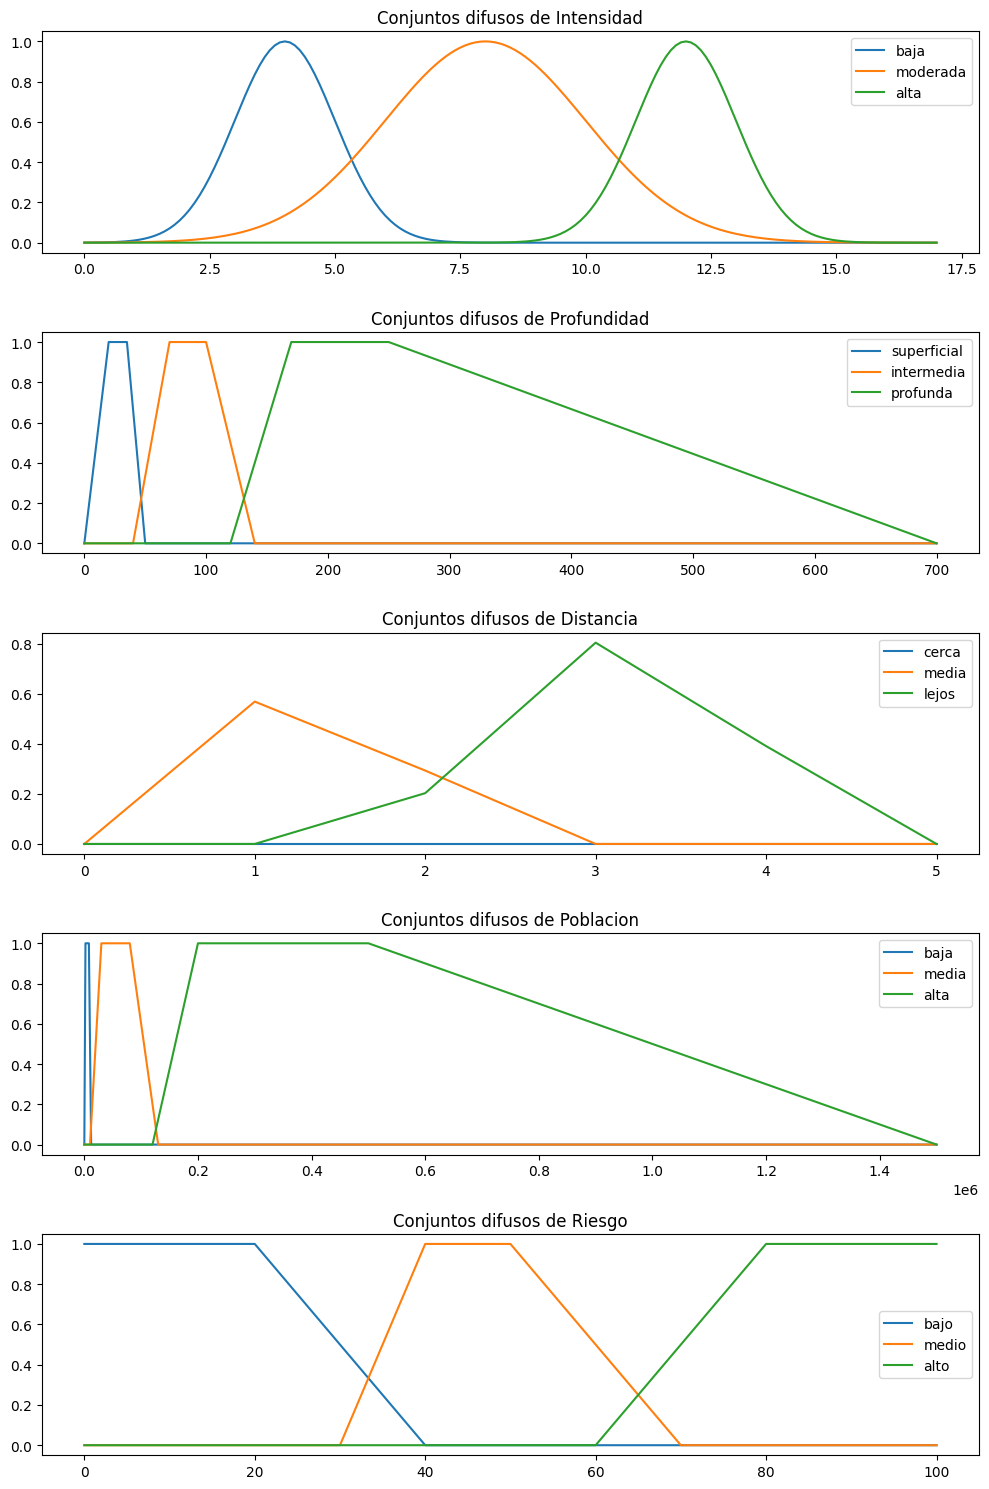

In [93]:
# Graficar los conjuntos difusos
variables = [intensidad, profundidad, distancia, poblacion, riesgo]
nombres = ['Intensidad', 'Profundidad', 'Distancia', 'Poblacion', 'Riesgo']

fig, axs = plt.subplots(len(variables), figsize=(10, 15))

for i, (variable, nombre) in enumerate(zip(variables, nombres)):
    for conjunto in variable.terms:
        axs[i].plot(variable.universe, variable[conjunto].mf, label=conjunto)
    axs[i].set_title(f'Conjuntos difusos de {nombre}')
    axs[i].legend()

plt.tight_layout()
plt.show()

In [147]:
print(intensidad.universe)
print(profundidad.universe)
print(distancia.universe)
print(poblacion.universe)


[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3
 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7
 16.8 16.9 17. ]
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.

In [148]:
# Definir las reglas
reglas = []

# Combinaciones de magnitud, profundidad, distancia y poblacion para definir el riesgo
combinaciones =[
    ('baja', 'superficial', 'cerca', 'baja', 'bajo'),
    ('baja', 'superficial', 'cerca', 'media', 'bajo'),
    ('baja', 'superficial', 'cerca', 'alta', 'bajo'),
    ('baja', 'superficial', 'media', 'baja', 'bajo'),
    ('baja', 'superficial', 'media', 'media', 'bajo'),
    ('baja', 'superficial', 'media', 'alta', 'bajo'),
    ('baja', 'superficial', 'lejos', 'baja', 'bajo'),
    ('baja', 'superficial', 'lejos', 'media', 'bajo'),
    ('baja', 'superficial', 'lejos', 'alta', 'bajo'),
    ('baja', 'intermedia', 'cerca', 'baja', 'medio'),
    ('baja', 'intermedia', 'cerca', 'media', 'medio'),
    ('baja', 'intermedia', 'cerca', 'alta', 'medio'),
    ('baja', 'intermedia', 'media', 'baja', 'medio'),
    ('baja', 'intermedia', 'media', 'media', 'medio'),
    ('baja', 'intermedia', 'media', 'alta', 'medio'),
    ('baja', 'intermedia', 'lejos', 'baja', 'bajo'),
    ('baja', 'intermedia', 'lejos', 'media', 'bajo'),
    ('baja', 'intermedia', 'lejos', 'alta', 'bajo'),
    ('baja', 'profunda', 'cerca', 'baja', 'alto'),
    ('baja', 'profunda', 'cerca', 'media', 'alto'),
    ('baja', 'profunda', 'cerca', 'alta', 'alto'),
    ('baja', 'profunda', 'media', 'baja', 'medio'),
    ('baja', 'profunda', 'media', 'media', 'medio'),
    ('baja', 'profunda', 'media', 'alta', 'medio'),
    ('baja', 'profunda', 'lejos', 'baja', 'bajo'),
    ('baja', 'profunda', 'lejos', 'media', 'bajo'),
    ('baja', 'profunda', 'lejos', 'alta', 'bajo'),
    ('moderada', 'superficial', 'cerca', 'baja', 'medio'),
    ('moderada', 'superficial', 'cerca', 'media', 'medio'),
    ('moderada', 'superficial', 'cerca', 'alta', 'medio'),
    ('moderada', 'superficial', 'media', 'baja', 'medio'),
    ('moderada', 'superficial', 'media', 'media', 'medio'),
    ('moderada', 'superficial', 'media', 'alta', 'medio'),
    ('moderada', 'superficial', 'lejos', 'baja', 'bajo'),
    ('moderada', 'superficial', 'lejos', 'media', 'bajo'),
    ('moderada', 'superficial', 'lejos', 'alta', 'bajo'),
    ('moderada', 'intermedia', 'cerca', 'baja', 'alto'),
    ('moderada', 'intermedia', 'cerca', 'media', 'alto'),
    ('moderada', 'intermedia', 'cerca', 'alta', 'alto'),
    ('moderada', 'intermedia', 'media', 'baja', 'alto'),
    ('moderada', 'intermedia', 'media', 'media', 'alto'),
    ('moderada', 'intermedia', 'media', 'alta', 'alto'),
    ('moderada', 'intermedia', 'lejos', 'baja', 'medio'),
    ('moderada', 'intermedia', 'lejos', 'media', 'medio'),
    ('moderada', 'intermedia', 'lejos', 'alta', 'medio'),
    ('moderada', 'profunda', 'cerca', 'baja', 'alto'),
    ('moderada', 'profunda', 'cerca', 'media', 'alto'),
    ('moderada', 'profunda', 'cerca', 'alta', 'alto'),
    ('moderada', 'profunda', 'media', 'baja', 'alto'),
    ('moderada', 'profunda', 'media', 'media', 'alto'),
    ('moderada', 'profunda', 'media', 'alta', 'alto'),
    ('moderada', 'profunda', 'lejos', 'baja', 'medio'),
    ('moderada', 'profunda', 'lejos', 'media', 'medio'),
    ('moderada', 'profunda', 'lejos', 'alta', 'medio'),
    ('alta', 'superficial', 'cerca', 'baja', 'alto'),
    ('alta', 'superficial', 'cerca', 'media', 'alto'),
    ('alta', 'superficial', 'cerca', 'alta', 'alto'),
    ('alta', 'superficial', 'media', 'baja', 'alto'),
    ('alta', 'superficial', 'media', 'media', 'alto'),
    ('alta', 'superficial', 'media', 'alta', 'alto'),
    ('alta', 'superficial', 'lejos', 'baja', 'medio'),
    ('alta', 'superficial', 'lejos', 'media', 'medio'),
    ('alta', 'superficial', 'lejos', 'alta', 'medio'),
    ('alta', 'intermedia', 'cerca', 'baja', 'alto'),
    ('alta', 'intermedia', 'cerca', 'media', 'alto'),
    ('alta', 'intermedia', 'cerca', 'alta', 'alto'),
    ('alta', 'intermedia', 'media', 'baja', 'alto'),
    ('alta', 'intermedia', 'media', 'media', 'alto'),
    ('alta', 'intermedia', 'media', 'alta', 'alto'),
    ('alta', 'intermedia', 'lejos', 'baja', 'alto'),
    ('alta', 'intermedia', 'lejos', 'media', 'alto'),
    ('alta', 'intermedia', 'lejos', 'alta', 'alto'),
    ('alta', 'profunda', 'cerca', 'baja', 'alto'),
    ('alta', 'profunda', 'cerca', 'media', 'alto'),
    ('alta', 'profunda', 'cerca', 'alta', 'alto'),
    ('alta', 'profunda', 'media', 'baja', 'alto'),
    ('alta', 'profunda', 'media', 'media', 'alto'),
    ('alta', 'profunda', 'media', 'alta', 'alto'),
    ('alta', 'profunda', 'lejos', 'baja', 'alto'),
    ('alta', 'profunda', 'lejos', 'media', 'alto'),
    ('alta', 'profunda', 'lejos', 'alta', 'alto'),
]


for magn, prof, dist, pobl, rieg in combinaciones:
    reglas.append(ctrl.Rule(intensidad[magn] & profundidad[prof] & distancia[dist] & poblacion[pobl], riesgo[rieg]))

# Crear el sistema de control difuso
control_riesgo = ctrl.ControlSystem(reglas)
simulacion_riesgo = ctrl.ControlSystemSimulation(control_riesgo)


In [149]:
def calcular_intensidad(distancia, magnitud):
    return 1.7*magnitud -4.82*np.log10(distancia) + 3.97

# Supongamos que la magnitud del terremoto está almacenada en una variable 'magnitud'

# Aplicar la fórmula a cada fila de la columna 'Distancia al Epicentro (km)', pasando la magnitud como un argumento adicional
distritos_en_area_efecto['INTENSIDAD'] = distritos_en_area_efecto['DISTANCIA'].apply(lambda x: calcular_intensidad(x, magnitud_momento))


In [150]:
ttt

,Geo Point,Geo Shape,CCDD,NOMBDEP,CCPP,NOMBPROV,CCDI,NOMBDIST,CAPITAL,UBIGEO,...,CODIGO,CNT_CCPP,DESCRIPCIO,POBLACION,FECHA,DAT_POB,geometry,DISTANCIA,INTENSIDAD,RIESGO
161,"-12.0510554271, -77.0490377322","{""coordinates"": [[[-77.00972298772564, -12.030...",15,LIMA,1,LIMA,1,LIMA,LIMA,150101,...,150101,1,LIMA,293647.0,2020.0,INEI,"POLYGON ((-77.00972 -12.03083, -77.00921 -12.0...",2.426336,7.214537,26.217298
167,"-12.0591441086, -77.0506366491","{""coordinates"": [[[-77.05334683838582, -12.049...",15,LIMA,1,LIMA,5,BREÑA,BREÑA,150105,...,150105,1,BREÑA,97431.0,2020.0,INEI,"POLYGON ((-77.05335 -12.04917, -77.05332 -12.0...",3.010892,6.762689,16.954340
228,"-12.0401247629, -76.9875419285","{""coordinates"": [[[-76.94637848577844, -12.021...",15,LIMA,1,LIMA,11,EL AGUSTINO,EL AGUSTINO,150111,...,150111,1,EL AGUSTINO,220858.0,2020.0,INEI,"POLYGON ((-76.94638 -12.02116, -76.94543 -12.0...",4.444316,5.947580,18.934224
809,"-12.0235974515, -77.0325879052","{""coordinates"": [[[-77.03077497828257, -11.997...",15,LIMA,1,LIMA,28,RIMAC,RIMAC,150128,...,150128,1,RIMAC,190288.0,2020.0,INEI,"POLYGON ((-77.03077 -11.99708, -77.03059 -11.9...",2.217403,7.403029,30.746076


In [159]:
simulacion_riesgo.input['intensidad'] = 7.5
simulacion_riesgo.input['profundidad'] = 33
simulacion_riesgo.input['distancia'] = 5
simulacion_riesgo.input['poblacion'] = 1000000
simulacion_riesgo.compute()
print(simulacion_riesgo.output['riesgo'])

ValueError: Crisp output cannot be calculated, likely because the system is too sparse. Check to make sure this set of input values will activate at least one connected Term in each Antecedent via the current set of Rules.

In [144]:

resultados_riesgo = []
ttt = distritos_en_area_efecto.head(4)
# Iterar sobre cada fila del DataFrame y calcular el riesgo
for index, row in ttt.iterrows():
    simulacion_riesgo.input['intensidad'] = row['INTENSIDAD']  # Puedes ajustar estos valores según tu caso
    simulacion_riesgo.input['profundidad'] = 33  # Puedes ajustar estos valores según tu caso
    simulacion_riesgo.input['distancia'] = row['DISTANCIA']
    simulacion_riesgo.input['poblacion'] = row['POBLACION']
    # Computar el resultado
    simulacion_riesgo.compute()
    # Obtener el resultado
    resultado_riesgo = simulacion_riesgo.output['riesgo']
    
    # Agregar el resultado a la lista
    resultados_riesgo.append(resultado_riesgo)

# Agregar los resultados al DataFrame original
distritos_en_area_efecto['RIESGO'] = pd.Series(resultados_riesgo, index=ttt.index)


/home/leon/Documentos/UNSA/IA/articulo-ia/venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [56]:

# Mostrar el DataFrame con los resultados de riesgo
distritos_en_area_efecto[['NOMBDIST' , 'NOMBPROV' ,'POBLACION','RIESGO', 'DISTANCIA' , 'INTENSIDAD']].head()

,NOMBDIST,NOMBPROV,POBLACION,RIESGO,DISTANCIA,INTENSIDAD
5,BARRANCA,BARRANCA,76776.0,54.655307,163.370643,6.052501
6,HUAURA,HUAURA,38493.0,53.347343,123.667736,6.635324
7,COCHAMARCA,OYON,1226.0,53.949324,128.735741,6.551250
8,LLAMELLIN,ANTONIO RAYMONDI,3571.0,18.401620,327.568252,4.596245
9,PAMPAROMAS,HUAYLAS,8757.0,18.232643,336.482847,4.540039


In [57]:
distritos_csv = distritos_en_area_efecto[['NOMBDIST' , 'NOMBPROV' , 'NOMBDEP', 'POBLACION' , 'INTENSIDAD' , 'DISTANCIA' ,'RIESGO']]
distritos_csv.to_csv('riesgo.csv')

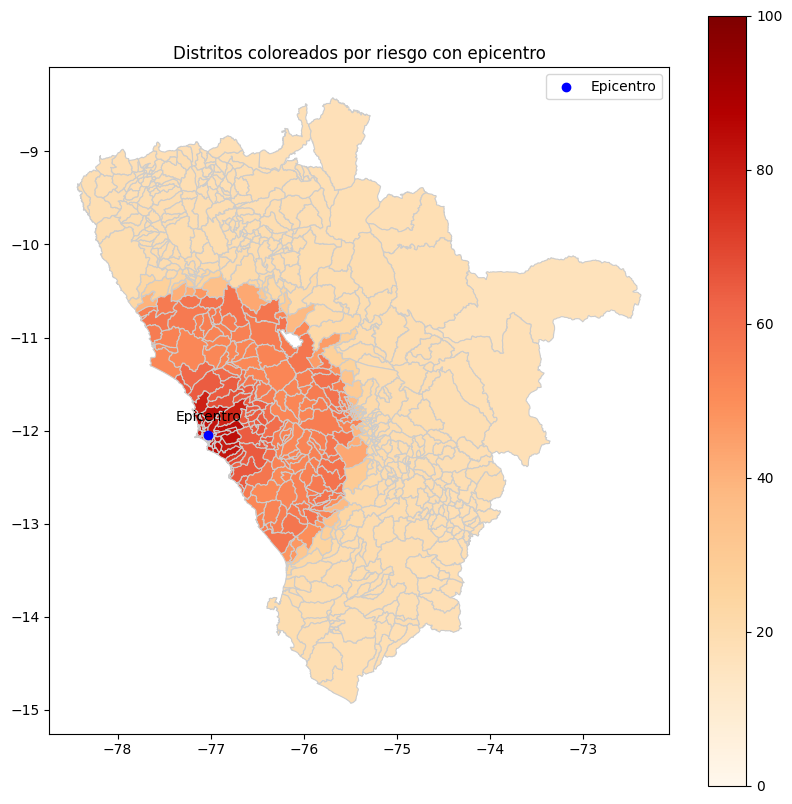

In [58]:
import geopandas as gpd
from matplotlib.colors import Normalize

# Convertir GeoJSON a geometría y añadirla al DataFrame
distritos_en_area_efecto['geometry'] = distritos_en_area_efecto['Geo Shape'].apply(convert_geojson_to_geometry)

# Crear un GeoDataFrame con la geometría actualizada
gdf = gpd.GeoDataFrame(distritos_en_area_efecto, geometry='geometry')

# Configurar la escala de color para el gráfico, límite máximo de 100
norm = Normalize(vmin=0, vmax=100)

# Graficar los distritos coloreados según el riesgo
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='riesgo', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, norm=norm)

# Graficar el epicentro
ax.scatter(epicentro_lon, epicentro_lat, color='blue', label='Epicentro', zorder=5)
ax.annotate('Epicentro', (epicentro_lon, epicentro_lat), textcoords="offset points", xytext=(0,10), ha='center')

# Configuración del título y leyenda del gráfico
plt.title('Distritos coloreados por riesgo con epicentro')
plt.legend()
plt.show()
